In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load full dataset
with open('full_train.pkl', 'rb') as f:
    full_train = pickle.load(f)  # Tuple (x_train, y_train)

with open('full_test.pkl', 'rb') as f:
    full_test = pickle.load(f)  # Tuple (x_test, y_test)

train_images, train_labels = full_train
test_images, test_labels = full_test

# Reshape data to be 28x28x1 and normalize pixel values
train_images = np.array(train_images).reshape((-1, 28, 28, 1)) / 255.0
train_labels = np.array(train_labels)
test_images = np.array(test_images).reshape((-1, 28, 28, 1)) / 255.0
test_labels = np.array(test_labels)

# Create validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

In [30]:
# Load the pre-trained model
base_model = load_model('base_cnn_model.keras')

for layer in base_model.layers[:-4]:  # Freeze all but the last 4 layers
    layer.trainable = False

base_model.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune using full training dataset
fine_tune_history = base_model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate accuracy on the full test set
_, test_acc = base_model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

In [27]:
#Saved Model Test accuracy: 0.9930999875068665
base_model.save('replay_fine-tuned_model.keras')

In [3]:
model = load_model('replay_fine-tuned_model.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9908 - loss: 0.0307
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Full test accuracy: 0.9931
Accuracy for digit 0: 0.9969


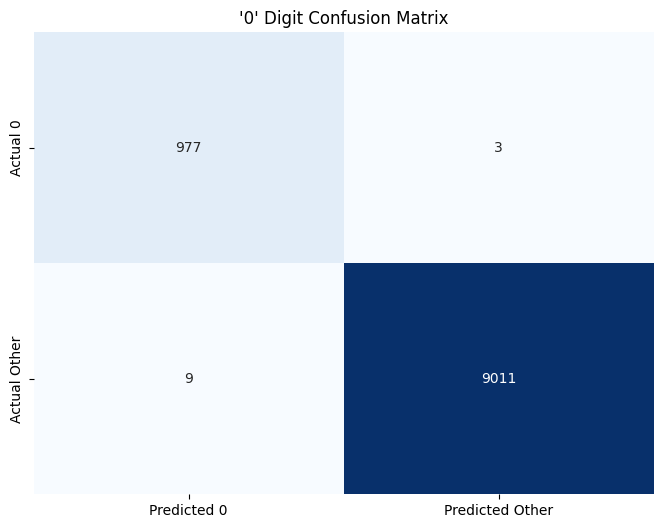

In [4]:
# Full test accuracy
_, test_acc = model.evaluate(test_images, test_labels)

# Accuracy for just digit '0'
# Get predictions for all test data
y_pred = np.argmax(model.predict(test_images), axis=1)

# Find indices of digit '0' in test set
zero_indices = np.where(test_labels == 0)[0]
zero_images = test_images[zero_indices]
zero_true_labels = test_labels[zero_indices]

# Get predictions for digit '0' samples
zero_pred = np.argmax(model.predict(zero_images), axis=1)

# Calculate accuracy for digit '0'
zero_accuracy = accuracy_score(zero_true_labels, zero_pred)

print(f'Full test accuracy: {test_acc:.4f}')
print(f'Accuracy for digit 0: {zero_accuracy:.4f}')

# Calculate number of false positives, false negatives, true positives, and true negatives for digit '0'
false_positives = np.sum((y_pred == 0) & (test_labels != 0))
false_negatives = np.sum((y_pred != 0) & (test_labels == 0))
true_positives = np.sum((y_pred == 0) & (test_labels == 0))
true_negatives = np.sum((y_pred != 0) & (test_labels != 0))

# Set up confusion matrix structure
conf_matrix = np.array([[true_positives, false_negatives], [false_positives, true_negatives]])

# Create confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted Other'], 
            yticklabels=['Actual 0', 'Actual Other'], 
            cbar=False)
plt.title("'0' Digit Confusion Matrix")
plt.show()